In [1]:
from dataclasses import asdict

import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import Network, Linear
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid

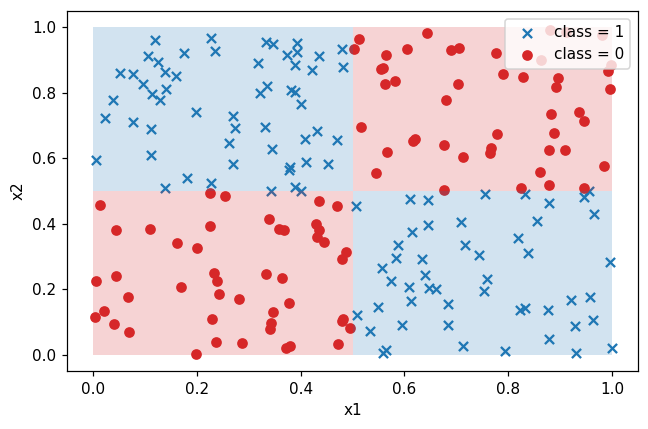

In [2]:
# Create a dataset
dataset_type = DatasetTypes.xor

datasets = Datasets.generate_datasets(n_samples=200)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

bottom_left = Rectangle((0, 0), 0.5, 0.5, color="tab:red", alpha=0.2, lw=0.0)
top_right = Rectangle((0.5, 0.5), 0.5, 0.5, color="tab:red", alpha=0.2, lw=0.0)
top_left = Rectangle((0.0, 0.5), 0.5, 0.5, color="tab:blue", alpha=0.2, lw=0.0)
bottom_right = Rectangle((0.5, 0.0), 0.5, 0.5, color="tab:blue", alpha=0.2, lw=0.0)
ax.add_patch(bottom_left)
ax.add_patch(bottom_right)
ax.add_patch(top_left)
ax.add_patch(top_right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

In [3]:
# Create a network
network = Network(input_dim=2, hidden_dim=5, output_dim=1)

In [4]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.3)

In [5]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [10]:
y_hat

[[Scalar(0.530, name=Variable737313)],
 [Scalar(0.511, name=Variable737314)],
 [Scalar(0.523, name=Variable737315)],
 [Scalar(0.539, name=Variable737316)],
 [Scalar(0.503, name=Variable737317)],
 [Scalar(0.533, name=Variable737318)],
 [Scalar(0.516, name=Variable737319)],
 [Scalar(0.505, name=Variable737320)],
 [Scalar(0.512, name=Variable737321)],
 [Scalar(0.539, name=Variable737322)],
 [Scalar(0.543, name=Variable737323)],
 [Scalar(0.532, name=Variable737324)],
 [Scalar(0.533, name=Variable737325)],
 [Scalar(0.540, name=Variable737326)],
 [Scalar(0.506, name=Variable737327)],
 [Scalar(0.541, name=Variable737328)],
 [Scalar(0.542, name=Variable737329)],
 [Scalar(0.548, name=Variable737330)],
 [Scalar(0.541, name=Variable737331)],
 [Scalar(0.518, name=Variable737332)],
 [Scalar(0.529, name=Variable737333)],
 [Scalar(0.525, name=Variable737334)],
 [Scalar(0.545, name=Variable737335)],
 [Scalar(0.553, name=Variable737336)],
 [Scalar(0.544, name=Variable737337)],
 [Scalar(0.558, name=Vari

In [6]:
# Training loop
n_epochs = 100
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]

    # Compute a loss
    loss_per_epoch = 0
    for i in range(len(y_true)):
        loss_per_epoch += (y_hat[i][0].log() if y_true[i] == 1.0 else (- y_hat[i][0] + 1).log())
    loss_per_epoch = (- loss_per_epoch / len(y_true))
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 0.8352802820238602
epoch 10: loss = 0.6943872952248626
epoch 20: loss = 0.6938496331542967
epoch 30: loss = 0.6934010098891819


KeyboardInterrupt: 

In [7]:
y_hat = network.forward(X)
y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
y_hat_classes = [[1 if proba.data >= 0.5 else 0 for proba in row] for row in y_hat]
y_hat_classes = list(itertools.chain.from_iterable(y_hat_classes))

In [8]:
# Accuraccy
sum(
    [
        1 if y_hat_c == y_true_c 
        else 0 for (y_hat_c, y_true_c) in zip(y_hat_classes, y_true)
    ]
) / len(y_true)

0.53

0.375

In [ ]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise decision boundaries

bias_positions = list(np.linspace(0, 2, 51))
x_range = list(np.linspace(0, 1, 51))

for bias_lower, bias_upper in zip(bias_positions, bias_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1, bias_lower - x1)) for x1 in x_range]
    
    # Clamp values to between 0.0 and 1.0
    X_lower = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_lower]
    y_lower = linear.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1, bias_upper - x1)) for x1 in x_range]
    
    # Clamp upper and lower bounds
    X_upper = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_upper]
    y_upper = linear.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_between(
        x_range,
        [x2 for (_, x2) in X_lower],
        [x2 for (_, x2) in X_upper],
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )
    

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();